<a href="https://colab.research.google.com/github/matpg/RL-Agent-for-Unreal-Engine-4/blob/main/Prueba_de_modelo_en_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tempfile

from matplotlib import pyplot as plt
import numpy as np
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.platform import gfile
import cv2


TensorFlow 1.x selected.


In [2]:
print(tf.version.VERSION)

1.15.2


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for device in physical_devices:
  tf.config.experimental.set_memory_growth(device, True)

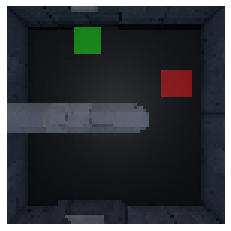

In [14]:
file = "/content/drive/MyDrive/Colab Notebooks/modelo ts agentnet/puzzle(9).jpg"
img = tf.keras.preprocessing.image.load_img(file, target_size=[72, 72])
plt.imshow(img)
plt.axis('off')
x = tf.keras.preprocessing.image.img_to_array(img)
img_to_test = x
img_to_test = np.array(img_to_test).reshape(1, 72, 72, 3)

In [10]:
rand_img = np.random.rand(1, 72, 72, 3)
rand_img2 = rand_img * 9.1

In [18]:
agentnet_save_path = '/content/drive/MyDrive/Colab Notebooks/modelo ts agentnet'

with tf.Session(graph=tf.Graph()) as sess:
  tf.saved_model.loader.load(sess, ["serve"], agentnet_save_path)    
  graph = tf.get_default_graph()
  print(graph.get_operations())
  print(graph.get_all_collection_keys())
  out = sess.run('output/Softmax:0', feed_dict={'input/Ob:0':img_to_test})
  print(out)
  print('Do number ' + str(np.argmax(out) + 1) + ' action.')
  # sess.run('output/Softmax:0'

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Colab Notebooks/modelo ts agentnet/variables/variables
[<tf.Operation 'input/Ob' type=Placeholder>, <tf.Operation 'input/Cast' type=Cast>, <tf.Operation 'input/sub/y' type=Const>, <tf.Operation 'input/sub' type=Sub>, <tf.Operation 'input/truediv/y' type=Const>, <tf.Operation 'input/truediv' type=RealDiv>, <tf.Operation 'model/c1/w/Initializer/initial_value' type=Const>, <tf.Operation 'model/c1/w' type=VariableV2>, <tf.Operation 'model/c1/w/Assign' type=Assign>, <tf.Operation 'model/c1/w/read' type=Identity>, <tf.Operation 'model/c1/b/Initializer/Const' type=Const>, <tf.Operation 'model/c1/b' type=VariableV2>, <tf.Operation 'model/c1/b/Assign' type=Assign>, <tf.Operation 'model/c1/b/read' type=Identity>, <tf.Operation 'model/c1/Reshape/shape' type=Const>, <tf.Operation 'model/c1/Reshape' type=Reshape>, <tf.Operation 'model/c1/Conv2D' type=Conv2D>, <tf.Operation 'model/c1/add' type=AddV2>, <tf.Operation 'model/Relu' type=Re

In [ ]:
#TENSORFLOW 2
agentnet_save_path = "/content/drive/MyDrive/Colab Notebooks/modelo ts agentnet"
loaded = tf.saved_model.load(sess=None, tags=['serve'], export_dir=agentnet_save_path)
print(list(loaded.signatures.keys()))  # ["serving_default"]

In [ ]:
agentnet = loaded

In [ ]:
infer = loaded.signatures["serving_default"]
print(infer.structured_outputs)

{'action': <tf.Tensor 'output/Softmax:0' shape=(None, 7) dtype=float32>}


In [ ]:
%cd {agentnet_save_path}

/content/drive/MyDrive/Colab Notebooks/modelo ts agentnet


In [ ]:
!saved_model_cli show --dir . --tag_set serve

In [ ]:
new_model = tf.keras.models.load_model(agentnet_save_path)
# Check its architecture
new_model

In [ ]:
#TENSORFLOW 2.0

img = cv2.imread(file)
flag, bts = cv2.imencode('.jpg', img)
inp = [bts[:,0].tobytes()]
loaded = tf.saved_model.load(export_dir=agentnet_save_path)
infer = loaded.signatures["serving_default"]
print(infer.graph)
print(infer.inputs)
print(infer.outputs)
print(infer.structured_input_signature)
print(infer.structured_outputs)
print(infer.name)
print(infer.variables)
out = infer(key=tf.constant(''), image_bytes=tf.constant(img))